# Autoscout24.ch Price Monitor

The idea is to get an automated (eventually daily) price overview for a specific type of car. But also exploratory data analysis done to find some patterns or the 'best' valued car for money. 
As Autoscout24.ch does not offer a free API, we use web scraping to get the data we are interested in. 
Weak point in this approach is the possibility of changes in the HTML structure. This would require changes also in the Jupyter notebook.
Note: The focus is on the BMW i3, but can be easily adopted for other cars

(c) Manuel Kohler, Basel, Switzerland

In [107]:
import sys
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import seaborn as sns
import altair as alt
import datetime
import os

# !{sys.executable} -m pip install numpy
# !pip install --upgrade pip --user

print(sys.version)

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]


In [108]:
output_folder = os.path.join('./output/')
try:
    os.mkdir(output_folder)
except OSError:
    pass

# First we load all the pages (needed due to pagination) which list the cars and extract the links to each individual car

In [84]:
baseurl = 'https://www.autoscout24.ch'
bmwi3_baseurl = baseurl + '/de/autos/bmw--i3'
# default is 20 cars per page, which would mean 20*10 cars
maxpages = 10

link_list = [] 

for i in range(1, maxpages):
    # fuel:16 = electro only, no REX
    # make:9 = BMW
    # model:1949 = i3    
    payload = {'fuel':16, 'make': '9', 'model': '1949', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}
    
    # Cayman S
    # payload = {'make': '62', 'model': '449', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}    
    
    # Tesla S
    # payload = {'fuel':16, 'make': '391', 'model': '1919', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}

    # VW e-Golf
    # payload = {'fuel':16, 'make': '82', 'model': '585', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}

    # VW Petrol Golf
    # payload = {'fuel':14, 'make': '82', 'model': '585', 'page': i, 'st': 1, 'vehtyp': 10, 'sort': 'price_asc'}


    print('Loading page: ', i)    
    r = requests.get(bmwi3_baseurl, params=payload)
    soup = BeautifulSoup(r.text, 'html.parser')
    
    # Searching now for such tags:
    # <a class="base-nav-link " data-qa="details-link" href="/de/d/bmw-i3-kleinwagen-2017-occasion?vehid=6797569&amp;backurl=%2Fautos%2Fbmw--i \
    # 3%3Ffuel%3D16%26make%3D9%26model%3D1949%26sort%3Dprice_asc%26page%3D2%26vehtyp%3D10&amp;fuel=16&amp;make=9&amp;model=1949&amp;sort=price_asc&amp;page=2&amp;vehtyp=10">
    
    # Documentation about find_all using a name argument: https://www.crummy.com/software/BeautifulSoup/bs4/doc/#the-name-argument
    car_links = soup.find_all(attrs={"data-qa": "details-link"})
#     print(car_links)
    
    # if no more new cars found we can exit the for loop. 
    # maxpages is then bigger than the real number of cars
    if (len(car_links) == 0):
        print(f"No more cars found after {i-1} iterations")
        break
    for car_link in car_links:
        link_list.append(car_link['href'])
        
print('Found ' + str(len(link_list)) + ' cars')

Loading page:  1
Loading page:  2
Loading page:  3
Loading page:  4
Loading page:  5
Loading page:  6
Loading page:  7
Loading page:  8
Loading page:  9
No more cars found after 8 iterations
Found 149 cars


In [85]:
def bmw_i3_name_cleaning(name):
    type = ''
    
    if ('i3s' in name):
        type = "i3s" 
    else:
        type = "i3"
 
    if ('60' in name):
        return (f'BMW {type} 60Ah')
    elif ('94' in name):
        return (f'BMW {type} 94Ah')
    elif ('120' in name):
        return (f'BMW {type} 120Ah')
    else:
        return (name)
    
def make_clean_number(dirty_string):
#     print('Cleaning ' + dirty_string)
    return int("".join([s for s in dirty_string if s.isdigit()]))

# Build a dataframe by extracting interesting features

In [86]:
car_list = []

for carIdx, carVal in enumerate(link_list):
    car = {}
        
    if (carIdx % 10 == 0) and (carIdx > 0):
        print(f"Downloaded {carIdx} cars")
    individual_car_request = requests.get(baseurl + carVal)
    soup = BeautifulSoup(individual_car_request.text, 'html.parser')
    
    # extract the individual vehical id given by autoscout, I assume that those are unique
    vehid = carVal.split("&")[0].split("=")[1]
    
    car['vehid'] = vehid
    car['carLink'] = '/'.join([baseurl, vehid])
    
    # The extraction of the price below is more elegant
    # <span class="mr-2 font-weight-bold h1">CHF 16'900.–</span>
    #raw_price = soup.find_all(class_="mr-2 font-weight-bold h1")
    #car['Preis'] = int("".join([s for s in raw_price[0].string if s.isdigit()]))
    
    title = soup.find("title").string.split(",")
    car['Name'] = bmw_i3_name_cleaning(title[0])
    try:
        car['Preis'] = int("".join([s for s in title[-1] if s.isdigit()]))
    except IndexError as e:
        print(f'Got:  {title}')
        car['Preis'] = 0
        

    # Now we tackle this part of html which is ugly to parse as autoscout replaced names with some SVGs
    #     <section class="details-specifications">
    #         <h2 class="font-weight-bold mb-3">Fahrzeugdaten</h2><div class="row"><div class="col-12 col-sm-6 col-md-8"><div class="row"><div class="col-12 col-md-6 mb-3">
    #         <div class="key-value "><div class="mr-2"><span class="base-icon d-r key-value-key bold-primary "><svg xmlns="http://www.w3.org/2000/svg" viewBox="0 0 24 24"><path d="M9 [...]
    #         0 0 0 2 2h14c1.1 0 2-.9 2-2V6c0-1.1-.9-2-2-2zm0 16H5V9h14v11z"></path></svg></span></div><span class="raw-html key-value-value ">12.2016</span>
    
    details_specifications = soup.find_all("section", class_="details-specifications")
    
    for details_specification in details_specifications:
        detail_values = details_specification.find_all("span", class_="raw-html key-value-value")
        
        try:
            car['Inverkehrsetzung'] = detail_values[0].string
            car ['Kilometer'] = make_clean_number(detail_values[1].string)
            car ['PS'] = detail_values[2].string.split(" ")[0]
            car ['Treibstoff'] = detail_values[3].string
            car ['Getriebeart'] = detail_values[4].string
            car ['Antriebsart'] = detail_values[5].string
        except IndexError as e:
            print(e)
            print(car)
    
    detailsVehSpecs = soup.find_all(id='detailsVehSpecs', class_='collapsible')
    for detailsVehSpec in detailsVehSpecs:
        minor_details = detailsVehSpec.find_all(class_='key-value')
        for minor_detail in minor_details:
            key_value_key = minor_detail.find_all('span', class_='raw-html key-value-key')
            key_value_value = minor_detail.find_all('span', class_='raw-html key-value-value bold-primary')
                #print(key_value_key[0].string)
            if 'Neupreis' in key_value_key[0].string or 'Leergewicht' in key_value_key[0].string:
                value = make_clean_number(key_value_value[0].string)
            else:
                value = key_value_value[0].string

            car[key_value_key[0].string.replace(":","")] = value
        
    car_list.append(car)

print(f"Downloaded {carIdx+1} car details in total.")

Downloaded 10 cars
Downloaded 20 cars
Downloaded 30 cars
Downloaded 40 cars
Downloaded 50 cars
Downloaded 60 cars
Downloaded 70 cars
Downloaded 80 cars
Downloaded 90 cars
Downloaded 100 cars
Downloaded 110 cars
Downloaded 120 cars
Downloaded 130 cars
Downloaded 140 cars
Downloaded 149 car details in total.


In [87]:
car_df = pd.DataFrame(car_list, dtype=object).fillna('0')

# Thanks for this hint:
# https://stackoverflow.com/questions/42263946/how-to-create-a-table-with-clickable-hyperlink-in-pandas-jupyter-notebook
def make_clickable(val):
    # target _blank to open new window
    return '<a target="_blank" href="{}">Link</a>'.format(val)

# Missing on the webpage, sort by the latest uploaded cars
# I assume that the vehid is similar to a DB sequence
car_df.sort_values(by=['vehid'], ascending=False).style.format({'carLink': make_clickable})

,Antriebsart,Aussenfarbe,Fahrgestell-Nr.,Fahrzeugart,Getriebeart,Innenfarbe,Inverkehrsetzung,Kilometer,Leergewicht,Letzte Prüfung,Name,Neupreis,PS,Preis,Sitze,Treibstoff,Typenschein,Türen,Wagen-Nr.,carLink,vehid
7,Hinterradantrieb,grau mét.,0,Occasion,Automatisiertes Schaltgetriebe,anthrazit,02.2015,49000,1270,09.02.2015,BMW i3 60Ah,0,170,19900,4,Elektro,1BE809,5,0,Link,6811208
14,Hinterradantrieb,weiss,0,Occasion,Automatisiertes Schaltgetriebe,0,06.2015,24500,1280,23.06.2015,BMW i3 60Ah,48650,170,20800,4,Elektro,1BE809,5,0,Link,6808287
0,Hinterradantrieb,weiss,0,Occasion,Automatisiertes Schaltgetriebe,grau,08.2014,84000,1270,26.06.2019,BMW i3 60Ah,0,170,16900,4,Elektro,1BE809,5,0,Link,6804590
92,Hinterradantrieb,weiss,0,Neu,Automatisiertes Schaltgetriebe,mehrfarbig,Neu,10,1426,0,BMW i3s 120Ah,57650,184,45990,4,Elektro,1BN689,5,7D69249,Link,6801980
93,Hinterradantrieb,weiss,0,Neu,Automatisiertes Schaltgetriebe,mehrfarbig,Neu,10,1426,0,BMW i3s 120Ah,57650,184,45990,4,Elektro,1BN689,5,7D69246,Link,6801903
29,Hinterradantrieb,protonic blue mét.,0,Occasion,Automatisiertes Schaltgetriebe,h'grau,05.2017,6300,1445,0,BMW i3 94Ah,53720,170,26800,4,Elektro,1BJ349,5,2056,Link,6801896
120,Hinterradantrieb,weiss,0,Vorführmodell,Automatisiertes Schaltgetriebe,grau,06.2019,2000,1426,0,BMW i3s 120Ah,58370,184,49999,4,Elektro,1BN689,5,0,Link,6801680
3,Hinterradantrieb,grau mét.,0,Occasion,Automatisiertes Schaltgetriebe,anthrazit,01.2014,44000,1270,0,BMW i3 60Ah,0,170,18800,4,Elektro,1BE809,5,0,Link,6798877
30,Hinterradantrieb,blau mét.,0,Occasion,Automatisiertes Schaltgetriebe,mehrfarbig,01.2017,12500,1445,0,BMW i3 94Ah,0,170,26800,4,Elektro,1BJ349,5,0,Link,6797569
24,Hinterradantrieb,weiss,0,Occasion,Automatisiertes Schaltgetriebe,Stoff anthrazit,12.2016,11300,1445,0,BMW i3 94Ah,0,170,25490,4,Elektro,1BJ349,5,20,Link,6795083


In [88]:
now = datetime.datetime.now().strftime('%d_%m_%Y_%H_%M_%S')
car_df.to_csv(f"./cars_{payload['make']}_{payload['model']}_{now}.csv", encoding='utf-8')
car_df.to_excel(f"./cars_{payload['make']}_{payload['model']}_{now}.xlsx", sheet_name='autoscout24.ch')

# ONLY For the BMW i3, the subgrouping makes sense

In [89]:
cars_120Ah = car_df[car_df['Name'].str.contains("120Ah")]
cars_94Ah = car_df[car_df['Name'].str.contains("94Ah")]
cars_60Ah = car_df[car_df['Name'].str.contains("60Ah")]

print(f"{len(cars_60Ah)} cars with 60Ah battery and {cars_60Ah.Kilometer.median()} median kilometers")
print(f"{len(cars_94Ah)} cars with 94Ah battery and {cars_94Ah.Kilometer.median()} median kilometers")
print(f"{len(cars_94Ah)} cars with 120Ah battery and {cars_120Ah.Kilometer.median()} median kilometers")

27 cars with 60Ah battery and 36000.0 median kilometers
64 cars with 94Ah battery and 7000.0 median kilometers
64 cars with 120Ah battery and 125.0 median kilometers


In [90]:
def plot_kilometers(df, title_prefix=''):
    kilometer_median = df.Kilometer.median()
    
    bar = alt.Chart(df).mark_bar().encode(
        x='vehid:O',
        y='Kilometer:Q',
        opacity=alt.value(0.8),
    )

    rule = alt.Chart(df).mark_rule(color='red').encode(
        y='median(Kilometer):Q'

    ).properties(
        title= title_prefix + ' Kilometers per car, Median '+ str(kilometer_median) +' in red, Ordered by ad age, n=' + str(len(df)))

    return (bar + rule).properties(height=300, width=1800)

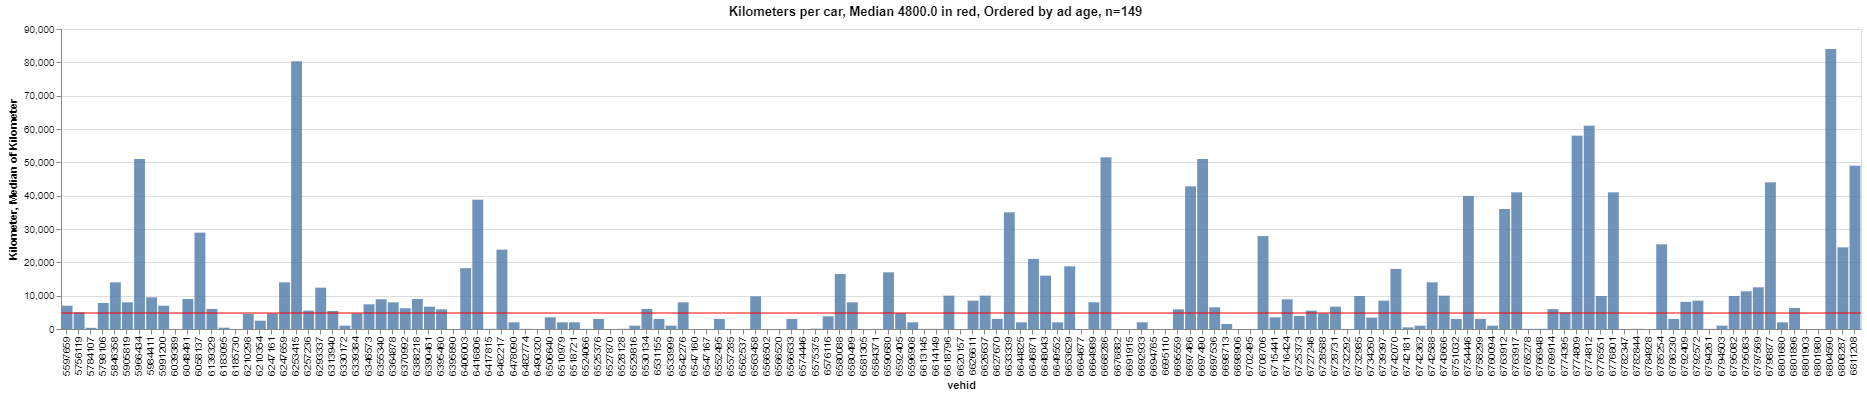

In [91]:
plot_kilometers(car_df)

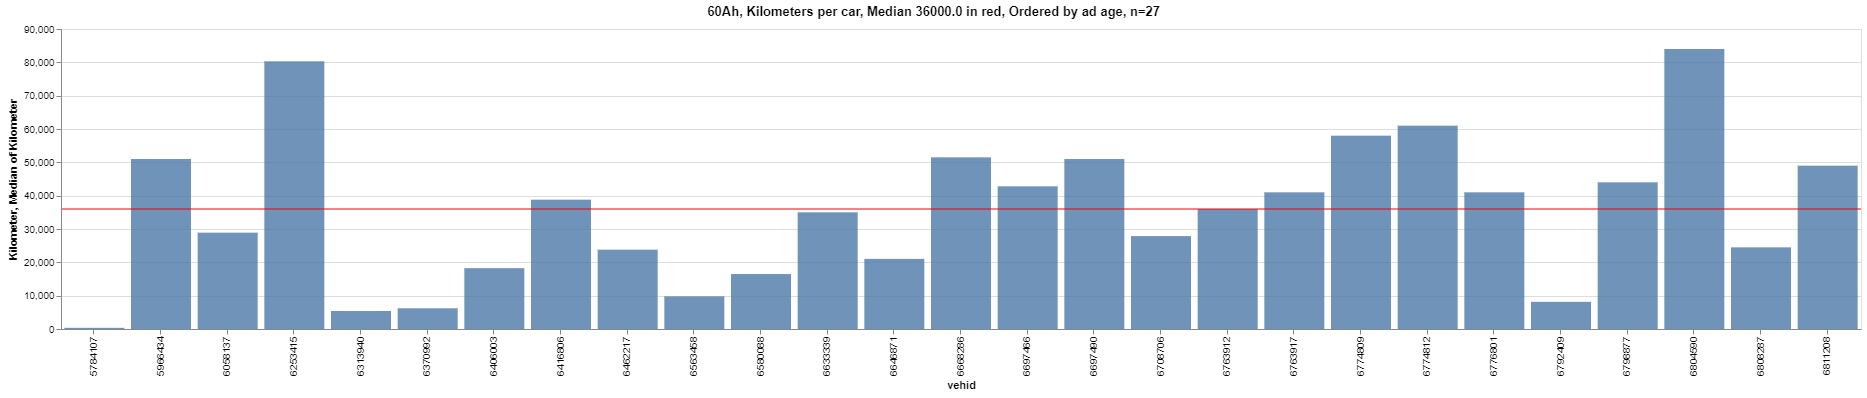

In [92]:
plot_kilometers(cars_60Ah, '60Ah,')

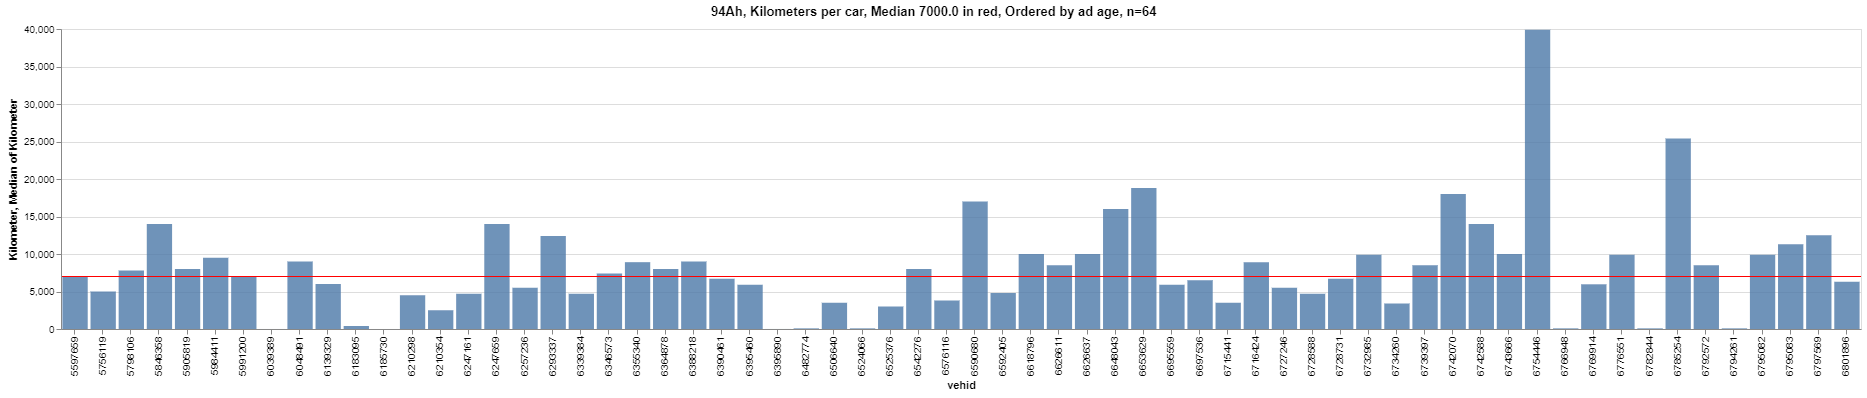

In [93]:
plot_kilometers(cars_94Ah, '94Ah,')

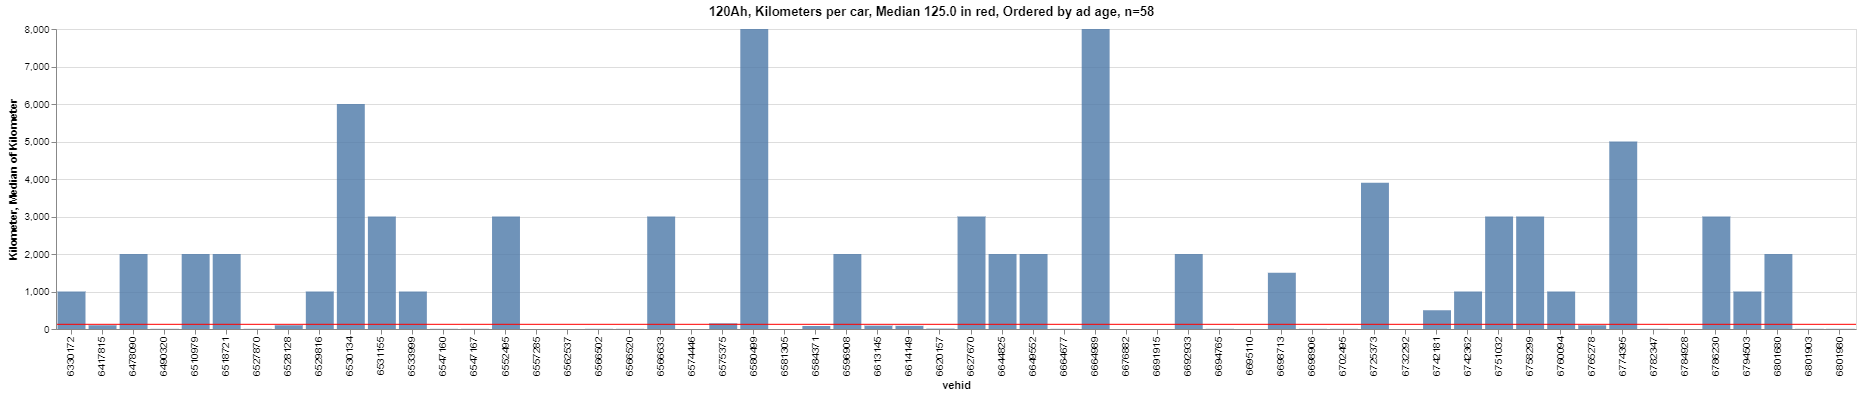

In [94]:
plot_kilometers(cars_120Ah, '120Ah,')

In [95]:
def plot_price(df, title_prefix=''):
    price_median = df.Preis.median()
    
    bar = alt.Chart(df).mark_bar().encode(
        x='vehid:O',
        y='Preis:Q',
        opacity=alt.value(0.8),
    )

    rule = alt.Chart(df).mark_rule(color='red').encode(
        y='median(Preis):Q'

    ).properties(
        title= title_prefix + ' Price per car, Median '+ str(price_median) +' in red, Ordered by ad age, n=' + str(len(df)))

    return (bar + rule).properties(height=300, width=2000)

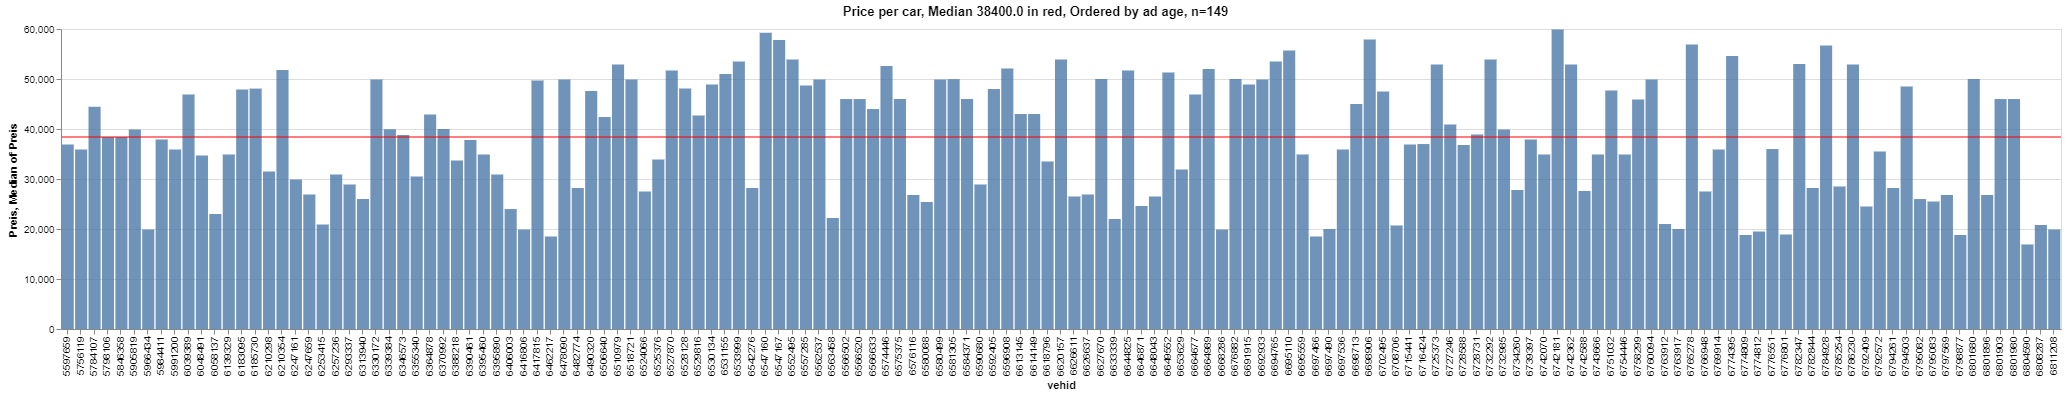

In [96]:
plot_price(car_df)

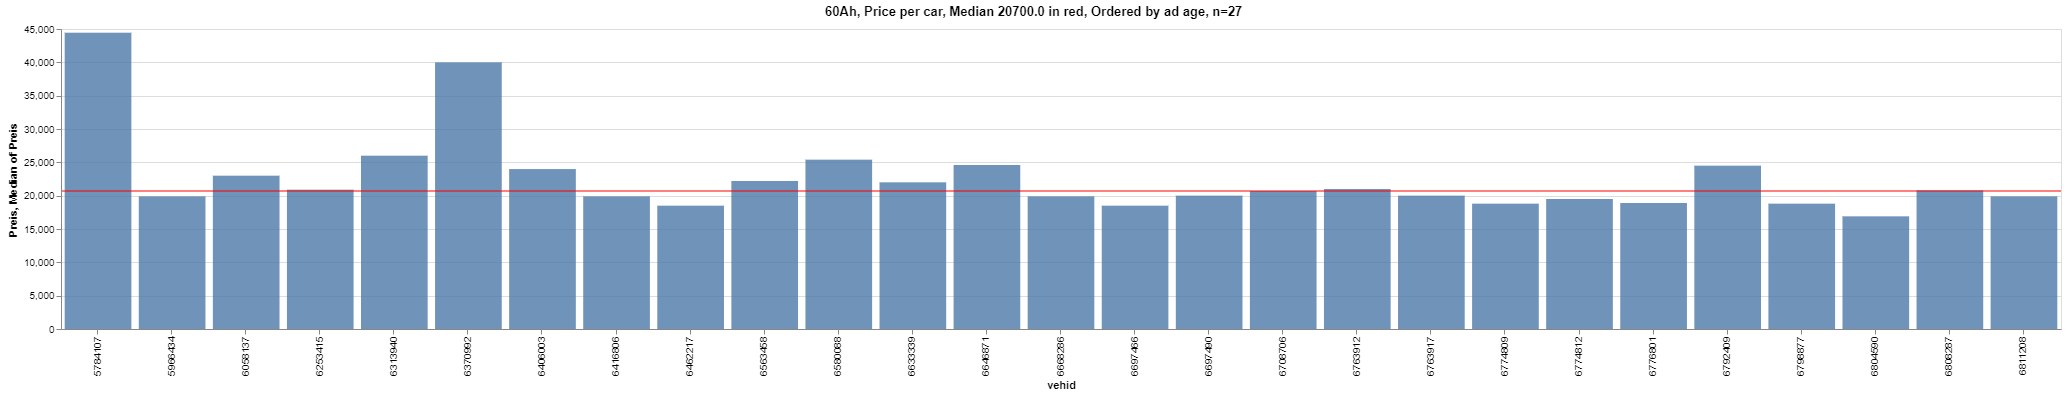

In [97]:
plot_price(cars_60Ah, '60Ah,')

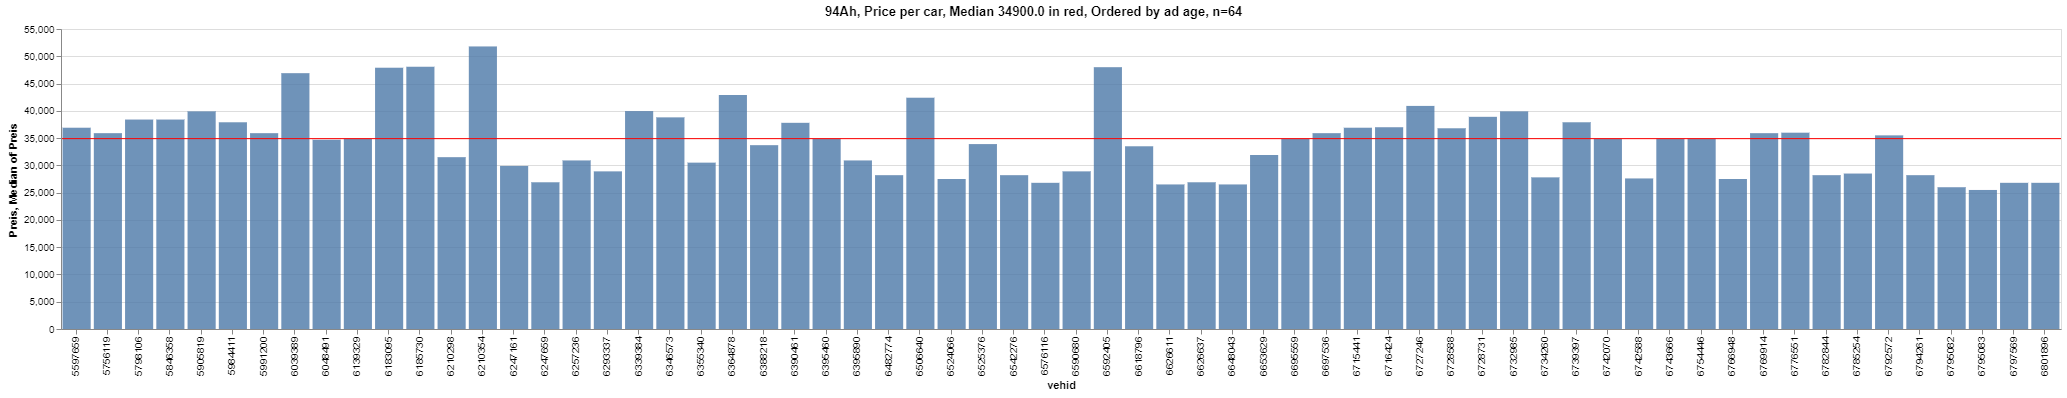

In [98]:
plot_price(cars_94Ah, '94Ah,')

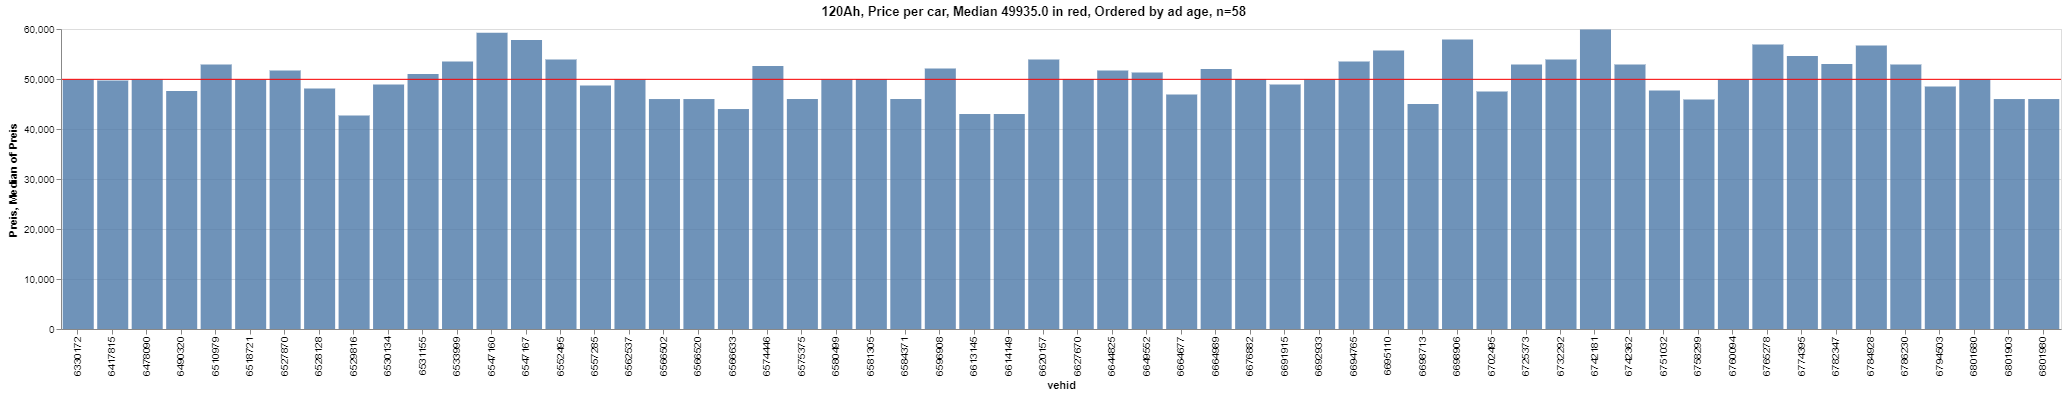

In [99]:
plot_price(cars_120Ah, '120Ah,')

# Interactive plot with tool tip

## You can Shift+click on an individual dot to open the car in autoscout

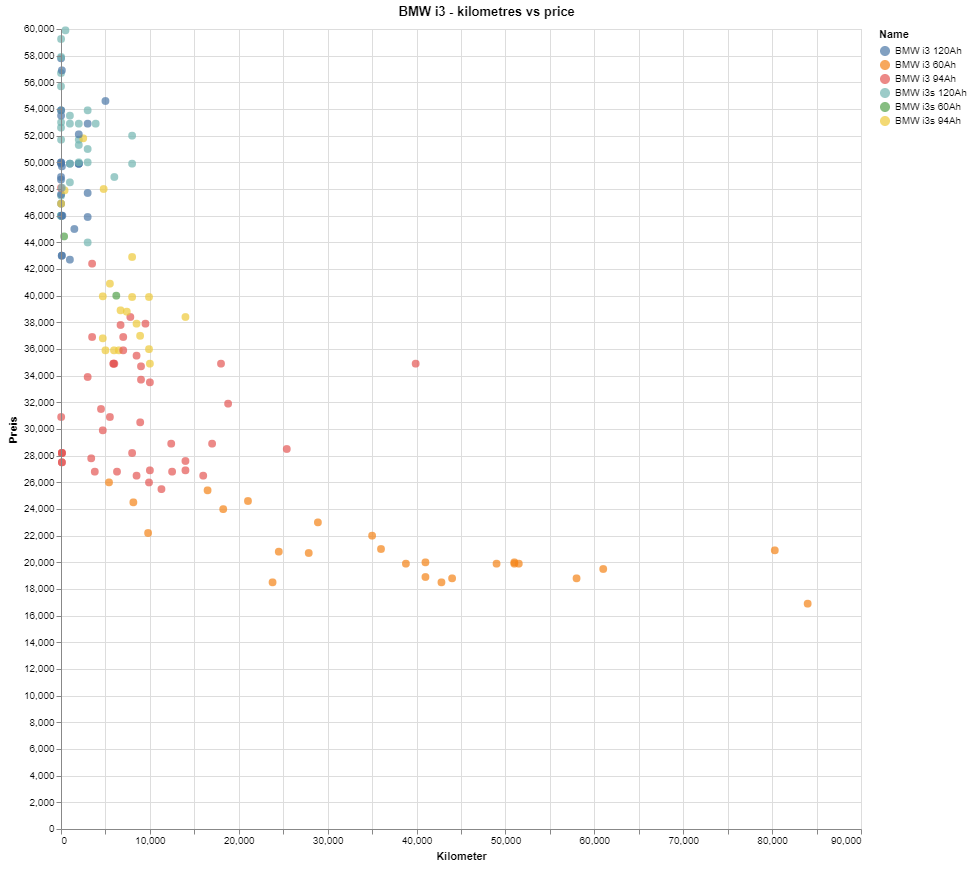

In [116]:
scatterplot = alt.Chart(car_df).mark_circle(size=60).encode(
    x='Kilometer',
    y='Preis',
    color='Name',
    tooltip=['Name', 'Preis', 'Kilometer', 'Inverkehrsetzung', 'vehid'],
    href='carLink:N',
#     '<a target="_blank" href="{}">Link</a>'.format(vehid)
    
   
).properties(title='BMW i3 - kilometres vs price')
# .interactive()

now = datetime.datetime.now().strftime('%d_%m_%Y_%H_%M_%S')
scatterplot.properties(width=1000, height=1000).save(os.path.join(output_folder, f"{now}_bmw_i3_kilometers_vs_price_.svg"))

(scatterplot).properties(height=800, width=800) 

In [115]:
import numpy as np

# Let's try a naive way of finding the car with the best value (obvislously a soft target)
# which in this simple approach means all the dots which have a short distance to the origin. No features
# are considered in this case.
# We can easily calculate this using good old Pythagoras

# a = car_df.copy()
# a['dist_to_origin'] = np.sqrt((car_df['Kilometer'])^2 + (car_df['Preis'])^2)
# a.sort_values(by=['dist_to_origin'])